In [1]:
!pip install pyspark

     |████████████████████████████████| 212.4MB 61kB/s 
     |████████████████████████████████| 204kB 17.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=f1e7e4927a285295d4f91e479f45e4b395f33c1dcfc7ce2127c9471b394d4566
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [ ]:
!pip install pyarrow==1.0.0

In [ ]:
!pip install fbprophet

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from fbprophet import Prophet

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [3]:
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()

In [4]:
df = pd.read_csv('/content/fyp_sales_dataset.csv')

In [5]:
df

,id,Date,Weekly_Sales
0,1,05/02/2014,1707.77
1,1,12/02/2014,1890.97
2,1,19/02/2014,2008.39
3,1,26/02/2014,1366.83
4,1,05/03/2014,1492.00
...,...,...,...
142710,998,28/09/2016,4364.69
142711,998,05/10/2016,7322.07
142712,998,12/10/2016,7733.20
142713,998,19/10/2016,5355.52


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142715 entries, 0 to 142714
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            142715 non-null  int64  
 1   Date          142715 non-null  object 
 2   Weekly_Sales  142715 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.3+ MB


In [7]:
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142715 entries, 0 to 142714
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            142715 non-null  int64         
 1   Date          142715 non-null  datetime64[ns]
 2   Weekly_Sales  142715 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.3 MB


In [9]:
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().any())
print ("\nUnique values :  \n",df.nunique())


Features : 
 ['id', 'Date', 'Weekly_Sales']

Missing values :   id              False
Date            False
Weekly_Sales    False
dtype: bool

Unique values :  
 id                 998
Date               144
Weekly_Sales    136314
dtype: int64


In [10]:
df

,id,Date,Weekly_Sales
0,1,2014-02-05,1707.77
1,1,2014-02-12,1890.97
2,1,2014-02-19,2008.39
3,1,2014-02-26,1366.83
4,1,2014-03-05,1492.00
...,...,...,...
142710,998,2016-09-28,4364.69
142711,998,2016-10-05,7322.07
142712,998,2016-10-12,7733.20
142713,998,2016-10-19,5355.52


In [11]:
df_base = df.copy()

In [12]:
df.describe()

,id,Weekly_Sales
count,142715.000000,142715.000000
mean,499.502659,19570.270410
std,288.099391,25741.264771
min,1.000000,-139.650000
25%,250.000000,3550.570000
50%,500.000000,10110.560000
75%,749.000000,24649.605000
max,998.000000,693099.360000


In [13]:
df['id'].value_counts()

879    144
895    143
936    143
554    143
426    143
      ... 
594    143
466    143
338    143
210    143
128    143
Name: id, Length: 998, dtype: int64

In [14]:
item_df = df.set_index('Date')

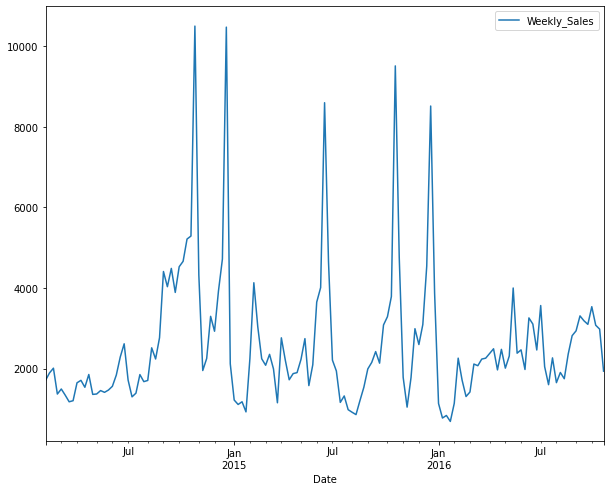

In [15]:
item_df.query("id==1")[['Weekly_Sales']].plot()

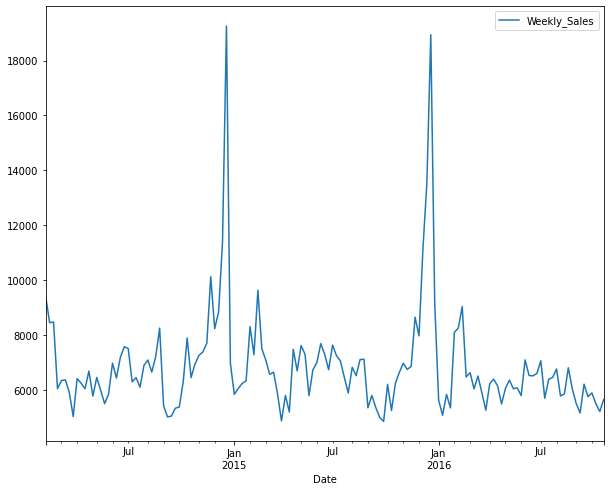

In [16]:
item_df.query("id==41")[['Weekly_Sales']].plot()

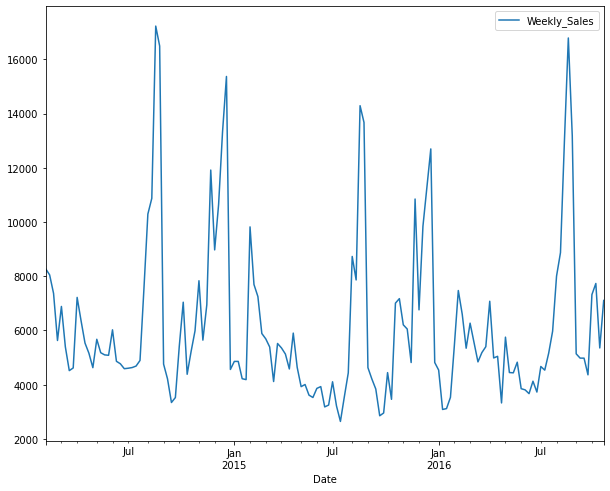

In [18]:
item_df.query("id==998")[['Weekly_Sales']].plot()

In [19]:
sdf = spark.createDataFrame(df)

In [20]:
sdf.show(5)

+---+-------------------+------------+
| id|               Date|Weekly_Sales|
+---+-------------------+------------+
|  1|2014-02-05 00:00:00|     1707.77|
|  1|2014-02-12 00:00:00|     1890.97|
|  1|2014-02-19 00:00:00|     2008.39|
|  1|2014-02-26 00:00:00|     1366.83|
|  1|2014-03-05 00:00:00|      1492.0|
+---+-------------------+------------+
only showing top 5 rows



In [21]:
sdf.printSchema()

root
 |-- id: long (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Weekly_Sales: double (nullable = true)



In [22]:
sdf.count() #no. of rows

142715

In [23]:
sdf.select(['id']).groupBy('id').agg({'id':'count'}).show()

+---+---------+
| id|count(id)|
+---+---------+
| 26|      143|
| 29|      143|
|474|      143|
|964|      143|
| 65|      143|
|191|      143|
|418|      143|
|541|      143|
|558|      143|
|222|      143|
|270|      143|
|293|      143|
|730|      143|
|938|      143|
|243|      143|
|278|      143|
|367|      143|
|442|      143|
|705|      143|
|720|      143|
+---+---------+
only showing top 20 rows



In [24]:
sdf.createOrReplaceTempView("Weekly_Sales")

In [25]:
spark.sql("select id, count(*) from Weekly_Sales group by id order by id").show()

+---+--------+
| id|count(1)|
+---+--------+
|  1|     143|
|  2|     143|
|  3|     143|
|  4|     143|
|  5|     143|
|  6|     143|
|  7|     143|
|  8|     143|
|  9|     143|
| 10|     143|
| 11|     143|
| 12|     143|
| 13|     143|
| 14|     143|
| 15|     143|
| 16|     143|
| 17|     143|
| 18|     143|
| 19|     143|
| 20|     143|
+---+--------+
only showing top 20 rows



In [26]:
sql = 'SELECT id, date as ds, sum(Weekly_Sales) as y FROM Weekly_Sales GROUP BY id, ds ORDER BY id, ds'

In [27]:
spark.sql(sql).show()

+---+-------------------+-------+
| id|                 ds|      y|
+---+-------------------+-------+
|  1|2014-02-05 00:00:00|1707.77|
|  1|2014-02-12 00:00:00|1890.97|
|  1|2014-02-19 00:00:00|2008.39|
|  1|2014-02-26 00:00:00|1366.83|
|  1|2014-03-05 00:00:00| 1492.0|
|  1|2014-03-12 00:00:00|1338.83|
|  1|2014-03-19 00:00:00|1174.83|
|  1|2014-03-26 00:00:00|1201.53|
|  1|2014-04-02 00:00:00| 1645.8|
|  1|2014-04-09 00:00:00|1706.83|
|  1|2014-04-16 00:00:00| 1535.0|
|  1|2014-04-23 00:00:00| 1852.0|
|  1|2014-04-30 00:00:00| 1358.0|
|  1|2014-05-07 00:00:00| 1368.0|
|  1|2014-05-14 00:00:00|1452.99|
|  1|2014-05-21 00:00:00| 1409.0|
|  1|2014-05-28 00:00:00|1465.99|
|  1|2014-06-04 00:00:00|1558.83|
|  1|2014-06-11 00:00:00|1837.99|
|  1|2014-06-18 00:00:00| 2285.0|
+---+-------------------+-------+
only showing top 20 rows



In [28]:
sdf.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[id#0L,Date#1,Weekly_Sales#2]




In [29]:
sdf.rdd.getNumPartitions()

1

In [30]:
store_part = (spark.sql( sql ).repartition(spark.sparkContext.defaultParallelism, ['id'])).cache()

In [31]:
store_part

DataFrame[id: bigint, ds: timestamp, y: double]

In [32]:
store_part.explain()

== Physical Plan ==
InMemoryTableScan [id#0L, ds#83, y#84]
   +- InMemoryRelation [id#0L, ds#83, y#84], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(id#0L, 1), REPARTITION_WITH_NUM, [id=#147]
            +- *(3) Sort [id#0L ASC NULLS FIRST, ds#83 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(id#0L ASC NULLS FIRST, ds#83 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#143]
                  +- *(2) HashAggregate(keys=[id#0L, date#1], functions=[sum(Weekly_Sales#2)])
                     +- Exchange hashpartitioning(id#0L, date#1, 200), ENSURE_REQUIREMENTS, [id=#139]
                        +- *(1) HashAggregate(keys=[id#0L, date#1], functions=[partial_sum(Weekly_Sales#2)])
                           +- *(1) Scan ExistingRDD[id#0L,Date#1,Weekly_Sales#2]




In [33]:
from pyspark.sql.types import *

result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('id',IntegerType()),
  StructField('y',DoubleType()),
  StructField('yhat',DoubleType()),
  StructField('yhat_upper',DoubleType()),
  StructField('yhat_lower',DoubleType())
  ])

In [104]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_sales( store_pd ):

  model = Prophet(interval_width=0.95,seasonality_mode = 'additive')

  model.fit( store_pd )

  future_pd = model.make_future_dataframe(
    periods=16, 
    freq='w-wed'
    )
  
  forecast_pd = model.predict(future_pd)  
  
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  st_pd = store_pd[['ds','id','y']].set_index('ds')
  
  results_pd = f_pd.join( st_pd, how='left' )

  results_pd.reset_index(level=0, inplace=True)
  
  results_pd['id'] = store_pd['id'].iloc[0]

  return results_pd[ ['ds', 'id','y', 'yhat', 'yhat_upper', 'yhat_lower'] ]  

In [106]:
from pyspark.sql.functions import current_date

results = (
  store_part
    .groupBy('id')
    .apply(forecast_sales)
    .withColumn('training_date', current_date() )
    )

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/group_ops.py:84: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [107]:
results.cache()

DataFrame[ds: timestamp, id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [108]:
results.show()

+-------------------+---+-------+------------------+------------------+-------------------+-------------+
|                 ds| id|      y|              yhat|        yhat_upper|         yhat_lower|training_date|
+-------------------+---+-------+------------------+------------------+-------------------+-------------+
|2014-02-05 00:00:00|  1|1707.77|2153.8906161100167|  4276.87033592485|-2.2624191239675033|   2021-06-26|
|2014-02-12 00:00:00|  1|1890.97|  2364.14215135614| 4479.486163050315| 27.102684903584436|   2021-06-26|
|2014-02-19 00:00:00|  1|2008.39|2089.9998500595434| 4590.067819310052| -336.2576417572419|   2021-06-26|
|2014-02-26 00:00:00|  1|1366.83| 1769.810361387978| 3983.815123609201| -718.9632617856595|   2021-06-26|
|2014-03-05 00:00:00|  1| 1492.0|1646.7121762055408| 3866.265039362184|  -566.563684696092|   2021-06-26|
|2014-03-12 00:00:00|  1|1338.83|1680.5274325100613| 3940.842802727643| -590.8174541921339|   2021-06-26|
|2014-03-19 00:00:00|  1|1174.83|1761.20065388

In [109]:
results.explain()

== Physical Plan ==
InMemoryTableScan [ds#1637, id#1638, y#1639, yhat#1640, yhat_upper#1641, yhat_lower#1642, training_date#1649]
   +- InMemoryRelation [ds#1637, id#1638, y#1639, yhat#1640, yhat_upper#1641, yhat_lower#1642, training_date#1649], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(2) Project [ds#1637, id#1638, y#1639, yhat#1640, yhat_upper#1641, yhat_lower#1642, 18804 AS training_date#1649]
            +- FlatMapGroupsInPandas [id#0L], forecast_sales(id#0L, ds#83, y#84), [ds#1637, id#1638, y#1639, yhat#1640, yhat_upper#1641, yhat_lower#1642]
               +- *(1) Sort [id#0L ASC NULLS FIRST], false, 0
                  +- InMemoryTableScan [id#0L, id#0L, ds#83, y#84]
                        +- InMemoryRelation [id#0L, ds#83, y#84], StorageLevel(disk, memory, deserialized, 1 replicas)
                              +- Exchange hashpartitioning(id#0L, 1), REPARTITION_WITH_NUM, [id=#147]
                                 +- *(3) Sort [id#0L ASC NULLS FIRST, d

In [110]:
results.coalesce(1) #unpartiion

DataFrame[ds: timestamp, id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [111]:
results.count()

158682

In [112]:
results.createOrReplaceTempView('forecasted')

In [113]:
spark.sql("select id, count(*) from forecasted group by id").show()

+---+--------+
| id|count(1)|
+---+--------+
|148|     159|
|463|     159|
|471|     159|
|496|     159|
|833|     159|
|243|     159|
|392|     159|
|540|     159|
|623|     159|
|737|     159|
|858|     159|
|897|     159|
| 31|     159|
|516|     159|
| 85|     159|
|137|     159|
|251|     159|
|451|     159|
|580|     159|
|808|     159|
+---+--------+
only showing top 20 rows



In [157]:
final_df = results.toPandas()

In [158]:
df.tail()

,id,Date,Weekly_Sales
142710,998,2016-09-28,4364.69
142711,998,2016-10-05,7322.07
142712,998,2016-10-12,7733.20
142713,998,2016-10-19,5355.52
142714,998,2016-10-26,7106.74


In [159]:
final_df.head(144)

,ds,id,y,yhat,yhat_upper,yhat_lower,training_date
0,2014-02-05,1,1707.77,2153.890616,4276.870336,-2.262419,2021-06-26
1,2014-02-12,1,1890.97,2364.142151,4479.486163,27.102685,2021-06-26
2,2014-02-19,1,2008.39,2089.999850,4590.067819,-336.257642,2021-06-26
3,2014-02-26,1,1366.83,1769.810361,3983.815124,-718.963262,2021-06-26
4,2014-03-05,1,1492.00,1646.712176,3866.265039,-566.563685,2021-06-26
...,...,...,...,...,...,...,...
139,2016-10-05,1,3534.87,3665.040340,5810.054099,1593.154085,2021-06-26
140,2016-10-12,1,3074.26,4576.605890,6776.706301,2256.847937,2021-06-26
141,2016-10-19,1,2977.80,5155.839988,7326.978288,2689.176001,2021-06-26
142,2016-10-26,1,1934.51,5009.922035,7237.305071,2648.475459,2021-06-26


In [160]:
final_df=final_df.set_index('ds')

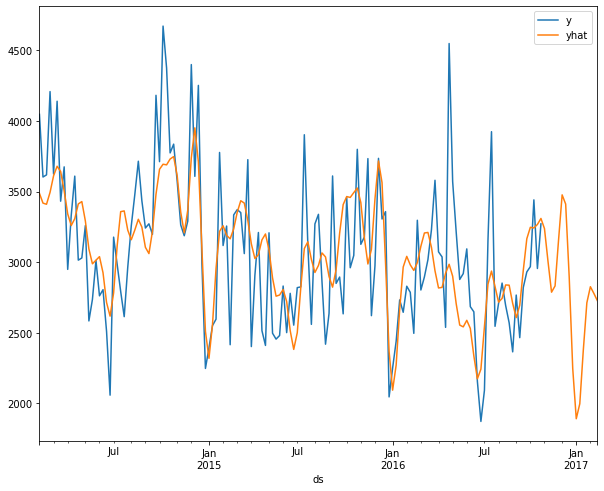

In [161]:
final_df.query('id==44')[['y','yhat']].plot()

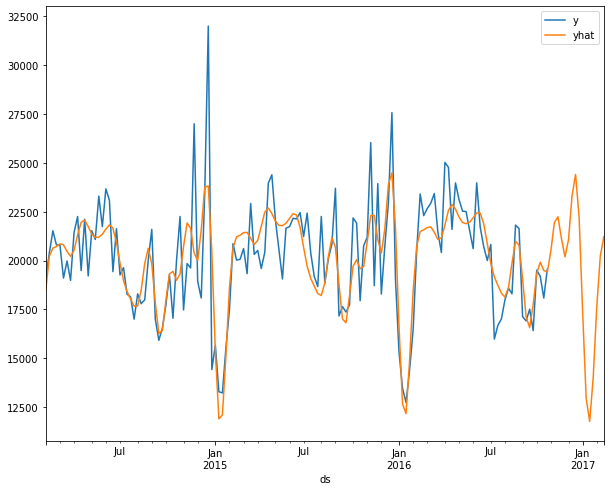

In [162]:
final_df.query('id==26')[['y','yhat']].plot() 

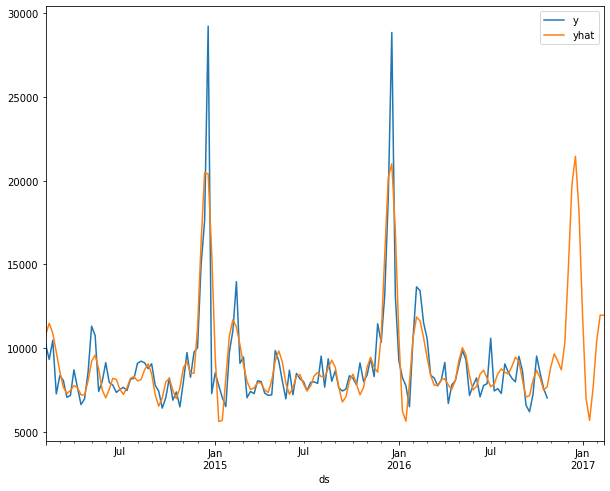

In [163]:
final_df.query('id==31')[['y','yhat']].plot()

In [173]:
data = final_df.copy()
data.tail()

,ds,id,y,yhat,yhat_upper,yhat_lower,training_date
158677,2017-01-18,998,NaN,3981.348485,6578.010161,1399.329133,2021-06-26
158678,2017-01-25,998,NaN,5523.472988,8185.758247,3059.872197,2021-06-26
158679,2017-02-01,998,NaN,7124.644684,9682.470679,4477.904325,2021-06-26
158680,2017-02-08,998,NaN,7973.195039,10467.408914,5202.546816,2021-06-26
158681,2017-02-15,998,NaN,7945.723286,10494.186361,5167.517857,2021-06-26


In [165]:
df_copy = df.set_index('Date')

In [166]:
df_copy.head()

,id,Weekly_Sales
Date,,
2014-02-05,1,1707.77
2014-02-12,1,1890.97
2014-02-19,1,2008.39
2014-02-26,1,1366.83
2014-03-05,1,1492.00


In [168]:
start_date = pd.date_range(start=df_copy.index.max(), periods=1, freq='W-WED')
print (start_date[0])

2016-11-02 00:00:00


In [169]:
final_df.reset_index(inplace=True)

In [208]:
next_week_sales = final_df.loc[final_df['ds'].isin([start_date[0]])]
next_week_sales.head()

,ds,id,y,yhat,yhat_upper,yhat_lower,training_date
143,2016-11-02,1,NaN,4151.249991,6407.531383,1899.960534,2021-06-26
302,2016-11-02,2,NaN,22432.300739,27589.650572,17218.347042,2021-06-26
461,2016-11-02,3,NaN,4866.453429,6072.028350,3694.613502,2021-06-26
620,2016-11-02,4,NaN,1606.795210,3026.550435,234.867210,2021-06-26
779,2016-11-02,5,NaN,12757.208691,15737.878489,10061.980474,2021-06-26


In [209]:
four_month_sales = final_df.loc[(final_df['ds'] > start_date[0])]
four_month_sales.head()

,ds,id,y,yhat,yhat_upper,yhat_lower,training_date
144,2016-11-09,1,NaN,2915.870494,5048.696726,609.883096,2021-06-26
145,2016-11-16,1,NaN,1829.102431,4068.002155,-388.855489,2021-06-26
146,2016-11-23,1,NaN,1479.999037,3672.622750,-847.752953,2021-06-26
147,2016-11-30,1,NaN,2252.734814,4578.405967,181.698865,2021-06-26
148,2016-12-07,1,NaN,3934.785038,6304.629607,1716.406468,2021-06-26


In [210]:
dataset = pd.read_csv('/content/fyp_dataset.csv')
dataset.head()

,asins,brand,categories,id,name,Price
0,B07DLYQ2R2,ALPINE REMEDY,Skin Care,1,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
1,B01M0PPX6F,Proud2beskin,Skin Care,2,[HOLIKA HOLIKA] Black Caviar Anti-Wrinkle Eye...,5785.0
2,B07FPW4LSV,Holika Holika,Skin Care,3,[Holika Holika] Spot Band Patch V Zone Patch 8g,2050.0
3,B00OOFIDHY,Innisfree,Skin Care,4,[Innisfree] Soybean Energy Essence Light 150ml,3089.0
4,B01N9K8CCZ,Leaders Insolution,Skin Care,5,[Leaders Insolution] Brightening Recovery Mas...,8458.0


In [211]:
next_week_df = pd.merge(next_week_sales,dataset,on='id',how='left')
next_week_df.head()

,ds,id,y,yhat,yhat_upper,yhat_lower,training_date,asins,brand,categories,name,Price
0,2016-11-02,1,NaN,4151.249991,6407.531383,1899.960534,2021-06-26,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
1,2016-11-02,2,NaN,22432.300739,27589.650572,17218.347042,2021-06-26,B01M0PPX6F,Proud2beskin,Skin Care,[HOLIKA HOLIKA] Black Caviar Anti-Wrinkle Eye...,5785.0
2,2016-11-02,3,NaN,4866.453429,6072.028350,3694.613502,2021-06-26,B07FPW4LSV,Holika Holika,Skin Care,[Holika Holika] Spot Band Patch V Zone Patch 8g,2050.0
3,2016-11-02,4,NaN,1606.795210,3026.550435,234.867210,2021-06-26,B00OOFIDHY,Innisfree,Skin Care,[Innisfree] Soybean Energy Essence Light 150ml,3089.0
4,2016-11-02,5,NaN,12757.208691,15737.878489,10061.980474,2021-06-26,B01N9K8CCZ,Leaders Insolution,Skin Care,[Leaders Insolution] Brightening Recovery Mas...,8458.0


In [212]:
four_month_sales_df = pd.merge(four_month_sales,dataset,on='id',how='left')
four_month_sales_df.head()

,ds,id,y,yhat,yhat_upper,yhat_lower,training_date,asins,brand,categories,name,Price
0,2016-11-09,1,NaN,2915.870494,5048.696726,609.883096,2021-06-26,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
1,2016-11-16,1,NaN,1829.102431,4068.002155,-388.855489,2021-06-26,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
2,2016-11-23,1,NaN,1479.999037,3672.622750,-847.752953,2021-06-26,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
3,2016-11-30,1,NaN,2252.734814,4578.405967,181.698865,2021-06-26,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
4,2016-12-07,1,NaN,3934.785038,6304.629607,1716.406468,2021-06-26,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0


In [213]:
next_week_df =next_week_df.drop(['y','yhat_upper','yhat_lower','training_date'], axis=1)
next_week_df.head()

,ds,id,yhat,asins,brand,categories,name,Price
0,2016-11-02,1,4151.249991,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
1,2016-11-02,2,22432.300739,B01M0PPX6F,Proud2beskin,Skin Care,[HOLIKA HOLIKA] Black Caviar Anti-Wrinkle Eye...,5785.0
2,2016-11-02,3,4866.453429,B07FPW4LSV,Holika Holika,Skin Care,[Holika Holika] Spot Band Patch V Zone Patch 8g,2050.0
3,2016-11-02,4,1606.795210,B00OOFIDHY,Innisfree,Skin Care,[Innisfree] Soybean Energy Essence Light 150ml,3089.0
4,2016-11-02,5,12757.208691,B01N9K8CCZ,Leaders Insolution,Skin Care,[Leaders Insolution] Brightening Recovery Mas...,8458.0


In [214]:
four_month_sales_df = four_month_sales_df.drop(['y','yhat_lower','training_date'], axis=1)


,ds,id,y,yhat,yhat_upper,yhat_lower,training_date
144,2016-11-09,1,NaN,2915.870494,5048.696726,609.883096,2021-06-26
145,2016-11-16,1,NaN,1829.102431,4068.002155,-388.855489,2021-06-26
146,2016-11-23,1,NaN,1479.999037,3672.622750,-847.752953,2021-06-26
147,2016-11-30,1,NaN,2252.734814,4578.405967,181.698865,2021-06-26
148,2016-12-07,1,NaN,3934.785038,6304.629607,1716.406468,2021-06-26


In [215]:
four_month_sales_df.head()

,ds,id,yhat,yhat_upper,asins,brand,categories,name,Price
0,2016-11-09,1,2915.870494,5048.696726,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
1,2016-11-16,1,1829.102431,4068.002155,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
2,2016-11-23,1,1479.999037,3672.622750,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
3,2016-11-30,1,2252.734814,4578.405967,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
4,2016-12-07,1,3934.785038,6304.629607,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0


In [218]:
next_week_df =next_week_df.rename(columns={ 'ds': 'Date', 'yhat': 'sales'})
next_week_df.head()

,Date,id,sales,asins,brand,categories,name,Price
0,2016-11-02,1,4151.249991,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
1,2016-11-02,2,22432.300739,B01M0PPX6F,Proud2beskin,Skin Care,[HOLIKA HOLIKA] Black Caviar Anti-Wrinkle Eye...,5785.0
2,2016-11-02,3,4866.453429,B07FPW4LSV,Holika Holika,Skin Care,[Holika Holika] Spot Band Patch V Zone Patch 8g,2050.0
3,2016-11-02,4,1606.795210,B00OOFIDHY,Innisfree,Skin Care,[Innisfree] Soybean Energy Essence Light 150ml,3089.0
4,2016-11-02,5,12757.208691,B01N9K8CCZ,Leaders Insolution,Skin Care,[Leaders Insolution] Brightening Recovery Mas...,8458.0


In [219]:
four_month_sales_df =four_month_sales_df.rename(columns={ 'ds': 'Date', 'yhat': 'sales'})
four_month_sales_df.head()

,Date,id,sales,yhat_upper,asins,brand,categories,name,Price
0,2016-11-09,1,2915.870494,5048.696726,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
1,2016-11-16,1,1829.102431,4068.002155,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
2,2016-11-23,1,1479.999037,3672.622750,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
3,2016-11-30,1,2252.734814,4578.405967,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0
4,2016-12-07,1,3934.785038,6304.629607,B07DLYQ2R2,ALPINE REMEDY,Skin Care,[ALPINE REMEDY] Blooming Cream 50ml BEST Kor...,3292.0


In [230]:
four_month_sales_df = four_month_sales_df.drop(columns='yhat_upper')

In [223]:
next_week_df.shape
four_month_sales_df.shape

(14970, 9)

In [232]:
next_week_df.to_csv('next_week_sales.csv', index=False)

In [233]:
four_month_sales_df.to_csv('four_months_sales.csv', index=False)

In [227]:
from google.colab import files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [235]:
files.download('next_week_sales.csv')
files.download('four_months_sales.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [174]:
data.dropna(inplace=True)
from sklearn.metrics import r2_score
r2_score(data['y'],data['yhat'])

0.9658516568956403